In [ ]:
import sys
py_exe = sys.executable
pkgs = """scikit-learn matplotlib numpy xgboost pandas nltk seaborn keyring requests html2text"""
!{py_exe} -m pip install --user {pkgs}

In [1]:
# import nltk
# nltk.download('stopwords')
from helper import *
%matplotlib inline

In [2]:
%%time
df = get_articles_df()
# df = get_articles_df(fetch_new=True)

CPU times: user 9.12 s, sys: 604 ms, total: 9.73 s
Wall time: 9.77 s


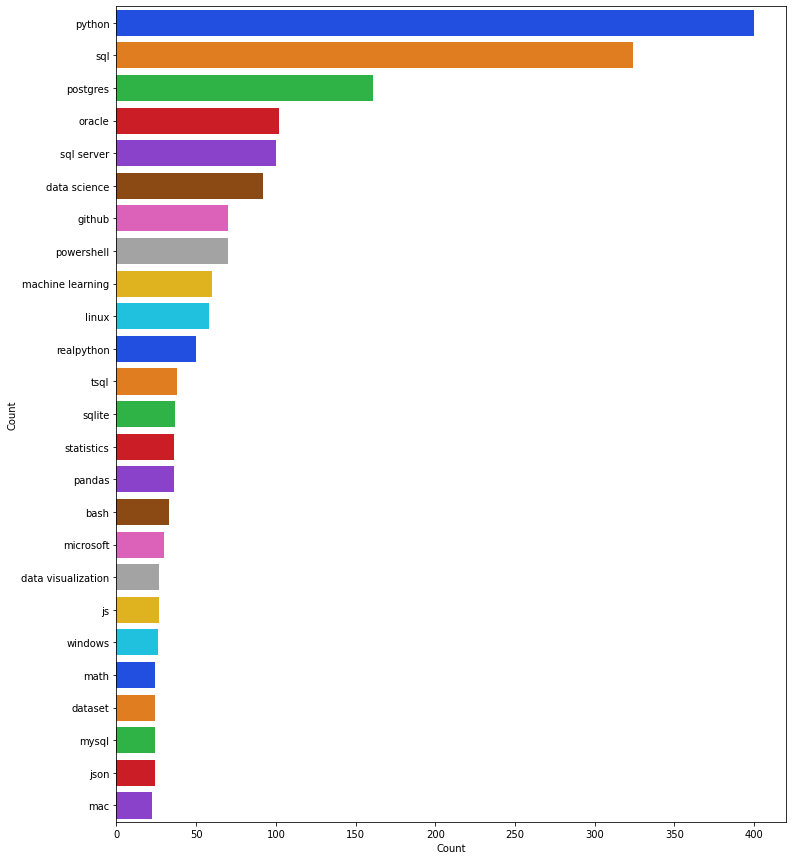

In [3]:
plot_tag_counts(df)

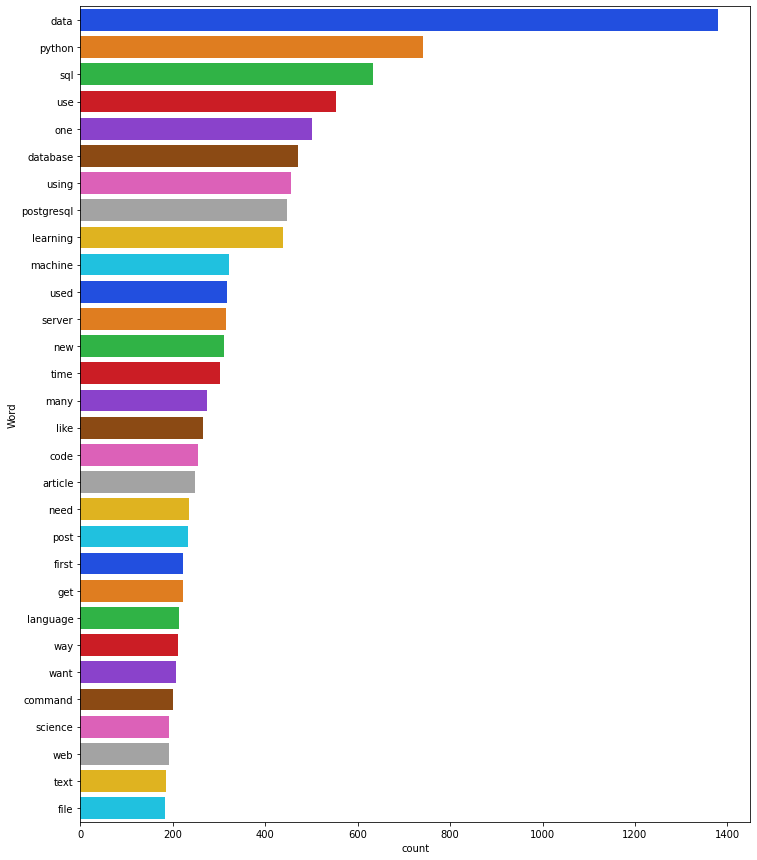

In [4]:
plot_word_frequencies(df.excerpt)

In [ ]:
%%time
def prep_data(initial_dataframe, text_col):
    df = initial_dataframe
    extract_tags = lambda x: list(ast.literal_eval(x).keys())

    df = df[['tags', text_col]]
    df['tags_cleaned'] = df[df.tags.notnull()].tags.apply(extract_tags)
    df = df[df.tags_cleaned.notnull()]
    df = df[df[text_col].notnull()]

    train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

    X_train = train[text_col]
    X_test = test[text_col]
    print(X_train.shape)
    print(X_test.shape)
    return X_train, X_test, train, test

# X_train, X_test, train, test = prep_data(df, 'excerpt')
X_train, X_test, train, test = prep_data(df, 'combined_text')

In [ ]:
%%time
from sklearn.metrics import precision_recall_fscore_support
# categories = get_categories(df)/
def make_models_nb(initial_df, text_col, X_train, X_test, train, test):
    df = initial_df
    def tag_counts(df):
        to_dict = lambda x: ast.literal_eval(x)
        tags = list(itertools.chain.from_iterable(
            df[df.tags.notnull()].tags.apply(lambda x: list(to_dict(x).keys())).values.tolist()
            ))
        tags = pd.DataFrame.from_dict(Counter(tags), orient='index').reset_index()
        tags.columns = ['Tag', 'Count']
        return tags.nlargest(columns="Count", n = 25) 

    categories = tag_counts(df).Tag.tolist()

    NB_pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                    ('clf', OneVsRestClassifier(MultinomialNB(
                        fit_prior=True, class_prior=None))),]) 

    models = {}
    for category in categories:
        has_tag = lambda x, tag: 1 if x and tag in x else 0
        temp_train, temp_test = train.copy(), test.copy()
        temp_train['has_tag'] = train.tags_cleaned.apply(lambda x: has_tag(x, category))
        temp_test['has_tag'] = test.tags_cleaned.apply(lambda x: has_tag(x, category))

        display(temp_train[temp_train[text_col].isnull()])
        print('... Processing {}'.format(category))
        NB_pipeline.fit(temp_train[text_col], temp_train['has_tag'])
        prediction = NB_pipeline.predict(temp_test[text_col])
#         print('Test accuracy is {}'.format(accuracy_score(temp_test['has_tag'], prediction)))
        print('Test accuracy is {}'.format(precision_recall_fscore_support(temp_test['has_tag'], prediction
                                                                          , average='micro')))
        models[category] = NB_pipeline
        
    return models
        
models = make_models_nb(df, 'excerpt' ,X_train, X_test, train, test)        

In [ ]:
def predict_tags(initial_dataframe, tag, text_col, models):
    df = initial_dataframe
    m = models[tag]
    preds = m.predict(df[text_col].values)
    preds = pd.DataFrame(zip(df[text_col].tolist(), preds.tolist()), 
                         columns=['text', 'prediction'])
    return preds
#     return preds[preds.prediction != 0]

# predict_tags(df, 'sql', 'excerpt', models)

In [ ]:
%%time
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import cohen_kappa_score

# categories = get_categories(df)/
def make_models_lr(initial_df, text_col, X_train, X_test, train, test):
    df = initial_df
    def tag_counts(df):
        to_dict = lambda x: ast.literal_eval(x)
        tags = list(itertools.chain.from_iterable(
            df[df.tags.notnull()].tags.apply(lambda x: list(to_dict(x).keys())).values.tolist()
            ))
        tags = pd.DataFrame.from_dict(Counter(tags), orient='index').reset_index()
        tags.columns = ['Tag', 'Count']
        return tags.nlargest(columns="Count", n = 25) 

    categories = tag_counts(df).Tag.tolist()

    LogReg_pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
                ])

    models = {}
    for category in categories:
        has_tag = lambda x, tag: 1 if x and tag in x else 0
        temp_train, temp_test = train.copy(), test.copy()
        temp_train['has_tag'] = train.tags_cleaned.apply(lambda x: has_tag(x, category))
        temp_test['has_tag'] = test.tags_cleaned.apply(lambda x: has_tag(x, category))

        display(temp_train[temp_train[text_col].isnull()])
        print('... Processing {}'.format(category))
        LogReg_pipeline.fit(temp_train[text_col], temp_train['has_tag'])
        prediction = LogReg_pipeline.predict(temp_test[text_col])
#         print('Test accuracy is {}'.format(accuracy_score(temp_test['has_tag'], prediction)))
#         print('Test accuracy is {}'.format(precision_recall_fscore_support(temp_test['has_tag'], prediction 
#                                                                           , average='weighted')))
        print('Test accuracy is {}'.format(cohen_kappa_score(temp_test['has_tag'], 
                                                                             prediction, labels=None, 
                                                                             weights=None)
                                          )
             )
        models[category] = LogReg_pipeline
        
    return models
        
# models_lr = make_models(df, 'excerpt' ,X_train, X_test, train, test) 
models_lr = make_models_lr(df, 'combined_text', X_train, X_test, train, test) 



# from sklearn.utils import resample
# # Separate majority and minority classes
# df_majority = df[df.balance==0]
# df_minority = df[df.balance==1]

# # Upsample minority class
# df_minority_upsampled = resample(df_minority, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=576,    # to match majority class
#                                  random_state=123) # reproducible results

# # Combine majority class with upsampled minority class
# df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# # Display new class counts
# df_upsampled.balance.value_counts()

In [ ]:
extract_tags = lambda x: list(ast.literal_eval(x).keys())
text_col = 'combined_text'
df = df[['tags', text_col]]
df['tags_cleaned'] = df[df.tags.notnull()].tags.apply(extract_tags)
df = df[df.tags_cleaned.notnull()]
df = df[df[text_col].notnull()]

In [ ]:
tdf = df[df.tags_cleaned.apply(lambda x: 'python' in x)][['combined_text', 'tags_cleaned']]
tdf['predicted'] = tdf.combined_text.apply(lambda x: models_lr['python'].predict([x]))
tdf.head(100)

In [ ]:
predict_tags(df, 'postgres', 'combined_text', models_lr)
# print(df.excerpt.values[0], models_lr['python'].predict([df.excerpt.values[0]]).tolist())

In [ ]:
# TODO -- Add lexing and stemming, look into fit_prior and class prior for NB, try Logistic Regression

In [ ]:
%%time
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import cohen_kappa_score
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

class XGBClassifierNew(XGBClassifier):

      def fit(self, X, y, **kwargs):
        weight = len(y)/y.sum()
        weight_array = y * weight
        return super().fit(X=X, y=y, sample_weight = weight_array, **kwargs)

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=100000)

# categories = get_categories(df)/
def make_models_xgb(initial_df, text_col, X_train, X_test, train, test):
    df = initial_df
    def tag_counts(df):
        to_dict = lambda x: ast.literal_eval(x)
        tags = list(itertools.chain.from_iterable(
            df[df.tags.notnull()].tags.apply(lambda x: list(to_dict(x).keys())).values.tolist()
            ))
        tags = pd.DataFrame.from_dict(Counter(tags), orient='index').reset_index()
        tags.columns = ['Tag', 'Count']
        return tags.nlargest(columns="Count", n = 25) 

    categories = tag_counts(df).Tag.tolist()

    models = {}
    for category in categories:
        has_tag = lambda x, tag: 1 if x and tag in x else 0
        temp_train, temp_test = train.copy(), test.copy()
        temp_train['has_tag'] = train.tags_cleaned.apply(lambda x: has_tag(x, category))
        temp_test['has_tag'] = test.tags_cleaned.apply(lambda x: has_tag(x, category))

#         xgb = XGBClassifier(scale_pos_weight=99)
        X_train = temp_train[text_col]
        X_test = temp_test[text_col]
        y_train = temp_train['has_tag']
        y_test = temp_test['has_tag']
        
        X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
        X_test_tfidf = tfidf_vectorizer.fit_transform(X_test)
        
        
#         pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
#                          ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
#         scores = cross_val_score(pl_xgb_tf_idf, df_x, df_y, cv=5)
#         print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())
        
        clf = OneVsRestClassifier(XGBClassifier(scale_pos_weight=99))
#         clf = OneVsRestClassifier(XGBClassifierNew())
#         mlb = MultiLabelBinarizer()
#         y_train = mlb.fit_transform(y_train)
        
#         display(temp_train[temp_train[text_col].isnull()])
        print('... Processing {}'.format(category))
        clf.fit(X_train_tfidf, y_train)
        prediction = clf.predict(X_train_tfidf)
f
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(clf, X_train_tfidf, y_train, 
                                 scoring='roc_auc', cv=cv, n_jobs=-1)
        print('Mean ROC AUC: %.5f' % np.mean(scores))
        
        models[category] = clf
        
    return models
        
models_xgb = make_models_xgb(df, 'combined_text', X_train, X_test, train, test) 


In [ ]:
# tdf = get_articles_df()
# extract_tags = lambda x: list(ast.literal_eval(x).keys())
# text_col = 'combined_text'
# tdf = tdf[['tags', text_col]]
# tdf['tags_cleaned'] = tdf[tdf.tags.notnull()].tags.apply(extract_tags)
# tdf = tdf[tdf.tags_cleaned.notnull()]
# tdf = tdf[tdf[text_col].notnull()]
# tdf = tdf[tdf.tags_cleaned.apply(lambda x: 'python' in x)][['combined_text', 'tags_cleaned']]
# tdf['predicted'] = tdf.combined_text.apply(lambda x: models_xgb['python'].predict(x))
# tdf.head(100)

In [ ]:
# %time
# # tdf = get_articles_df()
# f_names = models_xgb['python'].feature_names
# tdf[f_names]
# # models_xgb['python'].predict(tfidf_vectorizer.fit_transform(tdf[text_col]))
# tdf.head()
# train = pd.read_csv('train.csv').fillna(' ')#.sample(1000)
# test = pd.read_csv('test.csv').fillna(' ')#.sample(1000)
# %%time
df = get_articles_df()

In [5]:
%%time
def prep_dataframe(tdf, text_col):
    tdf = df[['item_id','tags', text_col]]
    tdf.tags = df.tags.fillna('{}') 
    extract_tags = lambda x: list(ast.literal_eval(x).keys())
    tdf['tag_list'] = tdf.tags.apply(extract_tags)

    def get_all_tags(df):
        to_dict = lambda x: ast.literal_eval(x)
        tags = set(itertools.chain.from_iterable(
            df.tags.apply(lambda x: list(to_dict(x).keys())).values.tolist()
            ))
        return list(tags)

    all_tags = get_all_tags(tdf)
    del tdf['tags']

    for t in all_tags:
        tdf[t] = np.NaN
        tdf[t] = tdf[t].fillna(0)
        tdf[t] = tdf[t].astype('int64') 

    for row in tdf.itertuples():
        for tag in all_tags:
            if tag in row.tag_list:
                tdf.at[row.Index, tag] = int(1)
            else:
                tdf.at[row.Index, tag] = int(0)
                
    return tdf, all_tags

tdf, all_tags = prep_dataframe(df, 'combined_text')

/Library/Python/3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Library/Python/3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Library/Python/3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

CPU times: user 4.8 s, sys: 33.9 ms, total: 4.83 s
Wall time: 4.86 s


In [6]:
%%time 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
import xgboost as xgb
from xgboost.sklearn import XGBClassifier # <3
from sklearn.model_selection import train_test_split
import gc

# class_names = ['python', 'postgres', 'sql']
class_names = all_tags

text_col = 'combined_text'
train, test = train_test_split(tdf, random_state=42, test_size=0.33, shuffle=True)

# train = pd.read_csv('../train.csv').fillna(' ')#.sample(1000)
# test = pd.read_csv('../test.csv').fillna(' ')#.sample(1000)

train_text = train[text_col]
test_text = test[text_col]
all_text = pd.concat([train, test])

train = train.loc[:,class_names]

print("TFIDF")
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    norm='l2',
    min_df=0,
    smooth_idf=False,
    max_features=15000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    norm='l2',
    min_df=0,
    smooth_idf=False,
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

train_features = hstack([train_char_features, train_word_features])
del train_char_features,train_word_features
test_features = hstack([test_char_features, test_word_features])
del test_char_features,test_word_features

print(train_features.shape)
print(test_features.shape)
d_test = xgb.DMatrix(test_features)
del test_features
gc.collect()

print("Modeling")
cv_scores = []
xgb_preds = []
submission = pd.DataFrame.from_dict({'item_id': test['item_id']})
errors = dict()
models = dict()
for class_name in class_names:
    try:
        train_target = train[class_name]
        # Split out a validation set
        X_train, X_valid, y_train, y_valid = train_test_split(
            train_features, train_target, test_size=0.25, random_state=23)

        xgb_params = {'eta': 0.3, 
                  'max_depth': 5, 
                  'subsample': 0.8, 
                  'colsample_bytree': 0.8, 
                  'objective': 'binary:logistic', 
                  'eval_metric': 'auc', 
                  'seed': 23
                 }

        d_train = xgb.DMatrix(X_train, y_train)
        d_valid = xgb.DMatrix(X_valid, y_valid)

        watchlist = [(d_valid, 'valid')]
        model = xgb.train(xgb_params, d_train, 200, watchlist, verbose_eval=False, early_stopping_rounds=30)
        print("class Name: {}".format(class_name))
        print(model.attributes()['best_msg'])
        cv_scores.append(float(model.attributes()['best_score']))
        submission[class_name] = model.predict(d_test)
        models[class_name.replace(' ', '_')] = model
        del X_train, X_valid, y_train, y_valid
        gc.collect()
    except Exception as e:
        errors[class_name] = e
        print(e)
    print('Total CV score is {}'.format(np.mean(cv_scores)))
# submission.to_csv('submission.csv', index=False)
save_models(models)
save_model_output(submission)

#TODO: Save errors as well
#TODO: Add xgb_params to save_models()
#TODO: Research Error -- https://github.com/dmlc/xgboost/issues/505

TFIDF


/Library/Python/3.7/site-packages/sklearn/feature_extraction/text.py:497: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


(2765, 2396)
(1363, 2396)
Modeling
[13:09:37] /Users/travis/build/dmlc/xgboost/src/metric/rank_metric.cc:233: Check failed: dat[1] > 0.0f (0 vs. 0) : AUC: the dataset only contains pos or neg samples
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000129bb61c0 dmlc::LogMessageFatal::~LogMessageFatal() + 112
  [bt] (1) 2   libxgboost.dylib                    0x0000000129c814dd xgboost::metric::EvalAuc::Eval(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, bool) + 2493
  [bt] (2) 3   libxgboost.dylib                    0x0000000129c5389d xgboost::LearnerImpl::EvalOneIter(int, std::__1::vector<std::__1::shared_ptr<xgboost::DMatrix>, std::__1::allocator<std::__1::shared_ptr<xgboost::DMatrix> > > const&, std::__1::vector<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::allocator<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > const&) + 1677
  [bt] (3) 4   libxgbo

/Library/Python/3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Python/3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


class Name: c#
[17]	valid-auc:1.00000
Total CV score is 1.0
[13:09:39] /Users/travis/build/dmlc/xgboost/src/metric/rank_metric.cc:233: Check failed: dat[1] > 0.0f (0 vs. 0) : AUC: the dataset only contains pos or neg samples
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000129bb61c0 dmlc::LogMessageFatal::~LogMessageFatal() + 112
  [bt] (1) 2   libxgboost.dylib                    0x0000000129c814dd xgboost::metric::EvalAuc::Eval(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, bool) + 2493
  [bt] (2) 3   libxgboost.dylib                    0x0000000129c5389d xgboost::LearnerImpl::EvalOneIter(int, std::__1::vector<std::__1::shared_ptr<xgboost::DMatrix>, std::__1::allocator<std::__1::shared_ptr<xgboost::DMatrix> > > const&, std::__1::vector<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::allocator<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > const&) + 16

In [3]:
output = pd.merge(left=pd.merge(left=submission, 
         right=df[['item_id', 'combined_text', 'resolved_title','resolved_url', 'tags']], 
         how='left', on=['item_id']), right=tdf[['item_id', 'tag_list']], on=['item_id'])

del output['tags']
output

In [8]:
df[df.combined_text.str.contains('dataframe')].resolved_title

2                        How to Build a Multi-label NLP Classifier from Scratch
3           Solving Multi-Label Classification problems (Case studies included)
4       Deep dive into multi-label classification..! (With detailed Case Study)
6                                            Introduction to Bayesian Inference
12      Using the Twitter API and NLP to analyze the tweets of different users.
                                         ...                                   
4005                            ​​​​Tutorial Using Excel with Python and Pandas
4089    Enabling sp_execute_external_script to run R scripts in SQL Server 2016
4118                                            Query Pandas DataFrame with SQL
4119                                                  SQL for pandas DataFrames
4121           10 Useful Python Data Visualization Libraries for Any Discipline
Name: resolved_title, Length: 773, dtype: object

In [57]:
# import os
# import glob
# for f in glob.glob('models/*.p'):
#     print(f)
#     os.remove(f)

In [53]:
# backup pocket.db
# import backup_db